# Downstream Task

## Object Detection on Digital Mammography

### Prepare and Learn the Dataset

In this problem, you are required to perform Object Detection on a subset of the [VinDr-Mammo benchmark](https://www.nature.com/articles/s41597-023-02100-7), which is a Vietnamese dataset consisting of 5,000 four-view exams of **digital mammography** with *breast-level assessment and extensive lesion-level annotations*. Each of these exams was independently double read, with discordance (if any) being resolved by arbitration by a third radiologist. This benchmark is designed as a new imaging resource to promote advances in developing computer-aided detection and diagnosis (CADe/x) tools for breast cancer screening.

Please check their [Introduction Webpage](https://vindr.ai/datasets/mammo), [Annotation Description](https://www.kaggle.com/datasets/hadighahroudi/vindr-mammo-dataset/data), and [Published Paper](https://www.nature.com/articles/s41597-023-02100-7) for more details.

In [3]:
# Download utility code and check GPU status
# Note do not run
!wget -q https://raw.githubusercontent.com/lisun-ai/EC500/main/homework3/anchor_utils.py
!wget -q https://raw.githubusercontent.com/lisun-ai/EC500/main/homework3/data_loader.py
!wget -q https://raw.githubusercontent.com/lisun-ai/EC500/main/homework3/model_blocks.py
!wget -q https://raw.githubusercontent.com/lisun-ai/EC500/main/homework3/model_utils.py
!wget -q https://raw.githubusercontent.com/lisun-ai/EC500/main/homework3/utils.py
!nvidia-smi

Sat Dec  6 15:00:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    On  |   00000000:49:00.0 Off |                    0 |
| N/A   32C    P8             33W /  350W |       0MiB /  46068MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
!nvidia-smi

Fri Dec 12 16:59:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    On  |   00000000:49:00.0 Off |                    0 |
| N/A   30C    P8             33W /  350W |       0MiB /  46068MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Problem 1.1 - Prepare Environment &  Dataset and Review Annotation File (5 Points)

Details on the original dataset can be found [here](https://www.physionet.org/content/vindr-mammo/1.0.0/).

We have preprocessed the DICOMs into [PNGs](https://www.kaggle.com/datasets/shantanughosh/vindr-mammogram-dataset-dicom-to-png) ([annotation CSV](https://github.com/batmanlab/Mammo-CLIP/blob/main/src/codebase/data_csv/vindr_detection_v1_folds.csv)) for this assignment for you.

If you are working on the SCC, the above data is provided in `/projectnb/batmanlab/ec500kb/materials/VinDr` and no paths in the following questions need be changed.

If you are not working on the SCC, you will have to download the images from the kaggle link above along with the metadata CSV and change paths in the below cells. This is not recommended.

Additionally, we highly recommend you make a separate environment from the last question to avoid any dependency errors. If you build a conda environment from [this config file](https://drive.google.com/file/d/1JQsKW8rL9qmHrSKAQWt-L2_y_dNd-olo/view?usp=sharing), the code should execute as intended.


Please explore the dataset using the provided codes:

In [2]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/projectnb/ec500kb/materials/VinDr/annotation.csv', low_memory=False)

# Print the shape of the file
print("Shape of the file:", df.shape, '\n\n')

# Print the number of unique "finding_categories"
num_unique_categories = df['finding_categories'].nunique()
print("Number of unique finding_categories:", num_unique_categories, '\n\n')

# Show all unique finding_categories
print("Unique finding_categories:")
print(df['finding_categories'].unique(), '\n\n')

# Show the first two lines and all information
print("First two lines with all information:")
print(df.head(2).to_string(index=False), '\n\n')


Shape of the file: (20486, 33) 


Number of unique finding_categories: 35 


Unique finding_categories:
["['Mass']" "['Global Asymmetry']" "['Architectural Distortion']"
 "['Nipple Retraction', 'Mass']"
 "['Suspicious Calcification', 'Focal Asymmetry']" "['Focal Asymmetry']"
 "['Asymmetry']" "['Suspicious Calcification']"
 "['Suspicious Calcification', 'Architectural Distortion']"
 "['Suspicious Calcification', 'Mass']" "['Skin Thickening']"
 "['Suspicious Lymph Node']" "['Nipple Retraction', 'Asymmetry']"
 "['Skin Thickening', 'Mass']" "['Asymmetry', 'Mass']"
 "['Architectural Distortion', 'Asymmetry']"
 "['Suspicious Calcification', 'Asymmetry']" "['Nipple Retraction']"
 "['Suspicious Calcification', 'Nipple Retraction', 'Mass']"
 "['Skin Retraction', 'Nipple Retraction', 'Mass']"
 "['Focal Asymmetry', 'Mass']"
 "['Nipple Retraction', 'Skin Thickening', 'Mass']" "['Skin Retraction']"
 "['Suspicious Calcification', 'Architectural Distortion', 'Mass']"
 "['Suspicious Calcification', 'A

In [4]:
import csv

input_filename = '/projectnb/ec500kb/materials/VinDr/annotation.csv'
output_filename = 'vin_dr_filtered_annotations.csv'

# bbox to clean
BBOX_COLUMNS = [
    "xmin", "ymin", "xmax", "ymax",
    "resized_xmin", "resized_ymin", "resized_xmax", "resized_ymax"
]

filtered_rows = []

with open(input_filename, newline='') as csvfile:
    reader = csv.DictReader(csvfile)

    # add Asymmetry_Combined to header
    fieldnames = reader.fieldnames + ["Asymmetry_Combined"]

    for row in reader:

        # 1. Fix empty bounding boxes
        for b in BBOX_COLUMNS:
            if row[b].strip() == "":
                row[b] = "-1"

        # 2. Compute combined asymmetry
        asym = int(row["Asymmetry"])
        focal = int(row["Focal_Asymmetry"])
        global_asym = int(row["Global_Asymmetry"])

        combined = 1 if (asym + focal + global_asym) > 0 else 0
        row["Asymmetry_Combined"] = str(combined)

        # 3. Zero out old asymmetry subclasses
        row["Asymmetry"] = "0"
        row["Focal_Asymmetry"] = "0"
        row["Global_Asymmetry"] = "0"

        # 4. Final lesion labels to check
        labels_to_check = [
            int(row["No_Finding"]),
            int(row["Mass"]),
            combined,
            int(row["Suspicious_Calcification"]),
        ]

        # 5. Keep if any label exists
        if sum(labels_to_check) >= 1:
            filtered_rows.append(row)

# Save updated annotations
with open(output_filename, 'w', newline='') as outfile:
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(filtered_rows)

print("Saved:", output_filename)
print("Rows included:", len(filtered_rows))

TARGET_COLUMNS = [
    #"No_Finding",
    "Mass",
    "Asymmetry_Combined",
    "Suspicious_Calcification"
]


Saved: vin_dr_filtered_annotations.csv
Rows included: 20266


In [5]:
import csv
import pandas as pd

# Read the CSV file
df = pd.read_csv('vin_dr_filtered_annotations.csv', low_memory=False)

# Print the shape of the file
print("Shape of the file:", df.shape, '\n\n')

# Print the number of unique "finding_categories"
num_unique_categories = df['finding_categories'].nunique()
print("Number of unique finding_categories:", num_unique_categories, '\n\n')

#### STUDENT'S CODE START HERE ####
# Show all unique finding_categories
print("Unique finding_categories:")

# Show the first two lines and all information
print("First two lines with all information:")
print(df.head(2).to_string(index=False), '\n\n')

# Show the number of training and testing data
# Filter the DataFrame to count the number of lines where the value in the "split" column is "training"
print("Number of training data:")
print(df[df['split'] == 'training'].shape[0], '\n')

# Filter the DataFrame to count the number of lines where the value in the "split" column is "testing"
print("Number of testing data:")
print(df[df['split'] == 'test'].shape[0], '\n')
#### STUDENT'S CODE END HERE ####

Shape of the file: (20266, 34) 


Number of unique finding_categories: 27 


Unique finding_categories:
First two lines with all information:
                      patient_id                        series_id                             image_id laterality view  height  width breast_birads breast_density finding_categories finding_birads        xmin        ymin        xmax        ymax    split  resized_xmin  resized_ymin  resized_xmax  resized_ymax  fold  Architectural_Distortion  Asymmetry  Focal_Asymmetry  Global_Asymmetry  Mass  Nipple_Retraction  No_Finding  Skin_Retraction  Skin_Thickening  Suspicious_Calcification  Suspicious_Lymph_Node  density  Asymmetry_Combined
48575a27b7c992427041a82fa750d3fa 26de4993fa6b8ae50a91c8baf49b92b0 4e3a578fe535ea4f5258d3f7f4419db8.png          R   CC    3518   2800     BI-RADS 4      DENSITY C           ['Mass']      BI-RADS 4 2355.139893 1731.640015 2482.979980 1852.750000 training    485.695624    985.773942    609.595900   1078.419728     0      

In [6]:
#!/usr/bin/env python3
import pandas as pd
import sys

NOT_ALLOWED_COLUMNS = [
    "patient_id","series_id","image_id", "finding_categories", "xmin",	"ymin", "xmax",	"ymax", "ROI_coords", "num_roi"
    "resized_xmin",	"resized_ymin", "resized_xmax",	"resized_ymax", "anon_dicom_path_short", "study_id", "desc", "anon_dicom_path",
]

def count_values(csv_path):
    print(f"\n[INFO] Loading CSV: {csv_path}")
    df = pd.read_csv(csv_path)

    print("\n===================== VALUE COUNTS PER COLUMN =====================\n")

    for col in df.columns:

        # ---------------------------------------
        # Check if column is allowed
        # ---------------------------------------
        if col in NOT_ALLOWED_COLUMNS:
            #print(f"[SKIP] Column '{col}' not in allowed list.\n")
            continue

        print(f"--- Column: {col} ---")
        try:
            counts = df[col].value_counts(dropna=False)
            for value, count in counts.items():
                print(f"  {value!r}: {count}")
        except Exception as e:
            print(f"  [ERROR processing column '{col}']: {e}")
        print()

    print("===================================================================\n")

if __name__ == "__main__":
    csv_path = '/projectnb/ec500kb/projects/Fall_2025_Projects/Project_3/Embed_classification_diagnostic_data_wo_dup_folds_update.csv'
    count_values(csv_path)


[INFO] Loading CSV: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_3/Embed_classification_diagnostic_data_wo_dup_folds_update.csv

===================== VALUE COUNTS PER COLUMN =====================

--- Column: BIRADS ---
  2: 17430
  3: 11728
  1: 11390
  4: 3546
  0: 926
  6: 473
  5: 243

--- Column: ImageLateralityFinal ---
  'L': 23321
  'R': 22415

--- Column: ViewPosition ---
  'CC': 24183
  'MLO': 21553

--- Column: num_roi ---
  0: 45538
  1: 181
  2: 15
  3: 2

--- Column: tissueden ---
  3.0: 20560
  2.0: 17939
  1.0: 4121
  4.0: 3116

--- Column: total_L_find ---
  1.0: 26880
  0.0: 17546
  2.0: 1048
  3.0: 187
  4.0: 39
  5.0: 29
  7.0: 4
  20.0: 2
  6.0: 1

--- Column: total_R_find ---
  1.0: 25980
  0.0: 18499
  2.0: 1078
  3.0: 118
  4.0: 37
  5.0: 18
  6.0: 4
  11.0: 2

--- Column: ETHNICITY_DESC ---
  'African American  or Black': 22031
  'Caucasian or White': 17733
  'Unknown, Unavailable or Unreported': 3100
  'Asian': 1874
  'Native Hawaiian or Other Paci

## Problem 1.2 - Implement the Intersection over Union (IoU) and the Cross-Entropy Loss (10 Points)

### Problem 1.2.1
The dimensionality of $a$ and $b$ are [num_boxes, 4], where 4 is [x_min, y_min, x_max, y_max]. Please implement the Intersection over Union (IoU) for object detection step by step:

<1> Calculate the area of $b$ box.

<2> Calculate the intersection width (iw) and intersection height (ih)

<3> Calculate the union area (ua) between $a$ and $b$

<4> Calculate the intersection area

<5> Calculate Intersection over Union (IoU)

### Problem 1.2.2
Cross entropy (CE) loss for binary classification:

\begin{equation}
\mathrm{CE}(p, y)= \begin{cases}-\log (p) & \text { if } y=1, \\ -\log (1-p) & \text { otherwise, }\end{cases}
\end{equation}

where $y \in\{ \pm 1\}$ specifies the ground-truth class and $p \in[0,1]$ is the model’s estimated probability for the class
with label $y = 1$.

In [7]:
import torch


def calc_iou(a, b):
    # Calculate the area of bounding boxes 'b'
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    # Calculate the intersection width (iw) and intersection height (ih)
    iw = torch.min(a[:, 2].unsqueeze(1), b[:, 2]) - torch.max(a[:, 0].unsqueeze(1), b[:, 0])
    ih = torch.min(a[:, 3].unsqueeze(1), b[:, 3]) - torch.max(a[:, 1].unsqueeze(1), b[:, 1])

    # Clamp the values of iw and ih to 0 to ensure non-negative values
    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)

    # Calculate the union area (ua) between 'a' and 'b'
    ua = ( (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]) ).unsqueeze(1) + area - (iw * ih)

    # Clamp the value of ua to avoid division by zero
    ua = torch.clamp(ua, min=1e-8)

    # Calculate the intersection area
    intersection = iw * ih

    # Calculate Intersection over Union (IoU)
    IoU = intersection / ua

    return IoU


## Problem 1.3 - Implement the Focal Loss (10 Points)

For this task, you are required to implement the Focal Loss, as described in [this paper](https://arxiv.org/pdf/1708.02002.pdf).

\begin{equation}
\mathrm{FL}\left(p_{\mathrm{t}}\right)=-\left(1-p_{\mathrm{t}}\right)^\gamma \log \left(p_{\mathrm{t}}\right),
\end{equation}

where

\begin{equation}
p_{\mathrm{t}}= \begin{cases}p & \text { if } y=1, \\ 1-p & \text { otherwise, }\end{cases}
\end{equation}

and $\gamma \geq 0$ is a tunable focusing parameter.

In [8]:
import torch
import torch.nn as nn


class FocalLoss(nn.Module):
    """Focal loss with optional per-class alpha and asymmetric gamma (pos vs neg)."""
    def __init__(self, focal_alpha, focal_gamma, focal_gamma_neg=None):
        super(FocalLoss, self).__init__()

        # focal_alpha can be: float, list/tuple, or 1D tensor
        if isinstance(focal_alpha, (list, tuple)):
            alpha = torch.tensor(focal_alpha, dtype=torch.float32)
        elif isinstance(focal_alpha, torch.Tensor):
            alpha = focal_alpha.float()
        else:
            # scalar -> keep as 1-element tensor
            alpha = torch.tensor([float(focal_alpha)], dtype=torch.float32)

        # register as buffer so it moves with the model to GPU
        self.register_buffer("alpha", alpha)

        # asymmetric gammas
        self.gamma_pos = float(focal_gamma)
        # if no separate negative gamma given, fall back to symmetric focal
        self.gamma_neg = float(focal_gamma_neg) if focal_gamma_neg is not None else self.gamma_pos

    def forward(self, classifications, regressions, anchors, annotations):
        batch_size = classifications.shape[0]
        classification_losses = []
        regression_losses = []

        anchor = anchors[0, :, :]
        anchor_widths = anchor[:, 2] - anchor[:, 0]
        anchor_heights = anchor[:, 3] - anchor[:, 1]
        anchor_ctr_x = anchor[:, 0] + 0.5 * anchor_widths
        anchor_ctr_y = anchor[:, 1] + 0.5 * anchor_heights
        device = classifications.device

        for j in range(batch_size):
            classification = classifications[j, :, :]
            regression = regressions[j, :, :]

            bbox_annotation = annotations[j, :, :]
            bbox_annotation = bbox_annotation[bbox_annotation[:, 4] != -1]

            if bbox_annotation.shape[0] == 0:
                regression_losses.append(torch.tensor(0).float().to(device))
                classification_losses.append(torch.tensor(0).float().to(device))
                continue

            # classification is already sigmoid outputs in most RetinaNet setups
            classification = torch.clamp(classification, 1e-4, 1.0 - 1e-4)

            # num_anchors x num_annotations
            IoU = calc_iou(anchors[0, :, :], bbox_annotation[:, :4])
            IoU_max, IoU_argmax = torch.max(IoU, dim=1)  # num_anchors x 1

            # compute the loss for classification
            targets = torch.ones(classification.shape, device=device) * -1
            targets[torch.lt(IoU_max, 0.4), :] = 0

            positive_indices = torch.ge(IoU_max, 0.5)
            num_positive_anchors = positive_indices.sum()
            assigned_annotations = bbox_annotation[IoU_argmax, :]

            targets[positive_indices, :] = 0
            targets[positive_indices, assigned_annotations[positive_indices, 4].long()] = 1

            # -------- PER-CLASS ALPHA (unchanged) --------
            num_classes = classification.shape[1]

            if self.alpha.numel() == 1:
                alpha_vec = self.alpha[0].expand(num_classes)        # same alpha for all classes
            else:
                assert self.alpha.numel() == num_classes, \
                    f"alpha length {self.alpha.numel()} must match num_classes {num_classes}"
                alpha_vec = self.alpha

            alpha_vec = alpha_vec.to(device)

            # alpha_pos[c] = alpha_c, alpha_neg[c] = 1 - alpha_c
            alpha_pos = alpha_vec.view(1, -1).expand_as(targets)     # [N, C]
            alpha_neg = (1.0 - alpha_vec).view(1, -1).expand_as(targets)

            alpha_factor = torch.where(torch.eq(targets, 1.0), alpha_pos, alpha_neg)

            # p_t = p if y=1 else (1-p)
            p_t = torch.where(torch.eq(targets, 1.0), classification, 1.0 - classification)

            # -------- ASYMMETRIC GAMMA (NEW PART) --------
            # for positives: (1 - p)^gamma_pos
            # for negatives: p^gamma_neg   (because 1 - p_t = p when y=0)
            gamma_pos = torch.full_like(targets, self.gamma_pos)
            gamma_neg = torch.full_like(targets, self.gamma_neg)
            gamma_factor = torch.where(torch.eq(targets, 1.0), gamma_pos, gamma_neg)

            focal_weight = alpha_factor * torch.pow(1.0 - p_t, gamma_factor)

            # standard BCE with p_t
            cls_loss = -focal_weight * torch.log(p_t)

            # ignore anchors where targets == -1
            cls_loss = torch.where(
                torch.ne(targets, -1.0),
                cls_loss,
                torch.zeros_like(cls_loss, device=device),
            )

            classification_losses.append(
                cls_loss.sum() / torch.clamp(num_positive_anchors.float(), min=1.0)
            )

            # ---------------- REGRESSION PART (unchanged) ----------------
            if positive_indices.sum() > 0:
                assigned_annotations = assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
                anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

                gt_widths = assigned_annotations[:, 2] - assigned_annotations[:, 0]
                gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
                gt_ctr_x = assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_ctr_y = assigned_annotations[:, 1] + 0.5 * gt_heights

                # clip widths to 1
                gt_widths = torch.clamp(gt_widths, min=1)
                gt_heights = torch.clamp(gt_heights, min=1)

                targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / anchor_widths_pi
                targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / anchor_heights_pi
                targets_dw = torch.log(gt_widths / anchor_widths_pi)
                targets_dh = torch.log(gt_heights / anchor_heights_pi)

                targets_reg = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh)).t()
                targets_reg = targets_reg / torch.tensor([[0.1, 0.1, 0.2, 0.2]], device=device)

                regression_diff = torch.abs(targets_reg - regression[positive_indices, :])
                regression_loss = torch.where(
                    torch.le(regression_diff, 1.0 / 9.0),
                    0.5 * 9.0 * torch.pow(regression_diff, 2),
                    regression_diff - 0.5 / 9.0,
                )
                regression_losses.append(regression_loss.mean())
            else:
                regression_losses.append(torch.tensor(0).float().to(device))

        return (
            torch.stack(classification_losses).mean(dim=0, keepdim=True),
            torch.stack(regression_losses).mean(dim=0, keepdim=True),
        )

### 🤔 **Question**: Why employing the Focal Loss is more effective than the Cross Entropy Loss? Please answer the question from the perspective of mathematical definitions of two losses. (5 Points)

### **YOUR ANSWER**:
Cross-entropy loss is defined as
\begin{equation}
L_{\mathrm{CE}} = -\log(p_t),
\end{equation}
which means that all samples contribute similarly to the loss, and even easy samples (i.e., samples for which the model already predicts the correct class with high confidence, ($p_t \to 1$) still produce non-negligible gradients. Focal Loss adds a confidence-based scaling term:
\begin{equation}
L_{\mathrm{FL}} = -\left(1 - p_t\right)^{\gamma} \log(p_t),
\end{equation}
and the factor $\left(1 - p_t\right)^{\gamma}$ becomes very small for easy samples ($p_t \to 1$) while remaining large for hard samples ($p_t \to 0$). This suppresses the loss from easy examples and focuses learning on hard or misclassified ones, making Focal Loss more effective than Cross-Entropy.

# 🚩 Task 2 - Training a Object Detection Model

To implement object detection, we will implement ResNet as the [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) backbone.

You are encouraged to read this [MONAI Tutorial](https://github.com/Project-MONAI/tutorials/tree/main/detection#detection-example) to learn more about the framework.

## Problem 2.1 - Building a ResNet Backbone (with Cross Entropy Loss) (15 Points)

In [9]:
import math

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torchvision.ops import nms

from anchor_utils import Anchors
from model_blocks import (
    BasicBlock,
    Bottleneck,
    ClassificationModel,
    RegressionModel,
    PyramidFeatures
)
from utils import BBoxTransform, ClipBoxes


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
}


def resnet18(num_classes, pretrained=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18'], model_dir='.'), strict=False)
    return model

### Problem (1):
**Implement the ResNet class:**

1. Set the initial value of self.inplanes to 64.
2. Create a convolutional layer (self.conv1) with parameters as follows:
    - Input channels: 3
    - Output channels: 64
    - Kernel size: 7 x 7
    - Stride: 2
    - Padding: 3
    - Bias: False
3. Add a batch normalization layer (self.bn1) with 64 channels.
4. Apply ReLU activation function (self.relu).
5. Add a max-pooling layer (self.maxpool) with kernel size 3 x 3, stride 2, and padding 1.
6. Create four layers (self.layer1, self.layer2, self.layer3, self.layer4) using the _make_layer method with the given parameters: block, 64, layers[0]; block, 128, layers[1], stride=2; block, 256, layers[2], stride=2; block, 512, layers[3], stride=2.


---

### Problem (2):

Please use the Cross Entropy Loss here.

---

### Problem (3):

**Implement the forward pass of the ResNet class:**

1. Complete the forward pass by passing the input batch through the convolutional layer, batch normalization layer, ReLU activation, and max-pooling layer.

2. Pass the resulting tensor through the layers of the ResNet block (self.layer1, self.layer2, self.layer3, self.layer4).

3. Finally, compute features using the FPN module with the provided intermediate features.

## Problem 2.2 - Training the Model (using Cross Entropy Loss) (5 Points)


You are required to use the built **ResNet** as the **retinanet backbone**.

(1) Please use your built resnet as the retinanet backbone in the `train_loop`.

(2) Please create the retinanet in the `inference_loop`.

In [10]:
import gc
import math
import os
import pickle
import time
import collections
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import torch
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from data_loader import get_transforms, get_dataset
from utils import (
    compute_accuracy,
    pfbeta_binarized,
    _get_detections,
    _get_annotations,
    _compute_ap,
    compute_overlap,
    asMinutes,
    timeSince,
    plot_concept_detector_results
)


def do_experiements(args, device):
    args.data_dir = Path(args.data_dir)
    args.df = pd.read_csv(args.data_dir / args.csv_file)
    print(args.data_dir / args.csv_file)
    args.df = args.df.fillna(0)
    print(f"df shape: {args.df.shape}")

    args.df = args.df.head(2254)
    if args.backbone == "resnet18":
        args.model_base_name = "ResNet"
    elif args.backbone == "mammoclip_b5":
        args.model_base_name = "MammoClipB5_C3C4C5"
    else:
        raise ValueError(f"Unknown backbone: {args.backbone}")
    args.cur_fold = 0
    args.train_folds = args.df[args.df['split'] == "training"].reset_index(drop=True)
    args.valid_folds = args.df[args.df['split'] == "test"].reset_index(drop=True)
    print(f'train: {args.train_folds.shape}', f'valid: {args.valid_folds.shape}')
    print(args.valid_folds.columns)

    if args.inference_mode == 'y':
        inference_loop(args, device)
    elif args.inference_mode == 'n':
        train_loop(args, device)

    print(f'Checkpoints saved at: {args.chk_pt_path}')
    print(f'Outputs saved at: {args.output_path}')

def _iou_xyxy(a, b):
    # a, b: [x1,y1,x2,y2]
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0.0, ix2 - ix1), max(0.0, iy2 - iy1)
    inter = iw * ih
    area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)
    union = area_a + area_b - inter + 1e-9
    return inter / union




def inference_loop(args, device):
    transform, _, test_affine_trans = get_transforms(args)

    # -------- Build model with all concepts --------
    num_classes = len(args.concepts)
    print("Inference with", num_classes, "classes:", args.concepts)
    retinanet = build_retinanet(args, device, num_classes=num_classes)
    retinanet.to(device)

    # -------- Load checkpoint --------
    ckpt_file = args.chk_pt_path / (
        f"{args.model_base_name}_seed_{args.seed}_fold_{args.cur_fold}_best_auroc.pth"
    )
    print("Loading checkpoint from:", ckpt_file)
    chk_pt = torch.load(ckpt_file, map_location=device, weights_only=False)
    retinanet.load_state_dict(chk_pt["state_dict"])
    retinanet.eval()
    print("model loaded")

    # For mapping concept -> class index used by RetinaNet
    concept_to_idx = {c: i for i, c in enumerate(args.concepts)}

    # We will NOT filter by Mass anymore; we want full valid set
    valid_df = args.valid_folds.copy()

    all_results = {}  # concept -> metrics dict
    th = args.score_threshold

    # -------- Loop over each concept separately --------
    for concept in args.concepts:
        print("\n====================")
        print("Evaluating concept:", concept)
        print("====================")

        class_idx = concept_to_idx[concept]

        args.image_path = args.output_path / concept
        os.makedirs(args.image_path, exist_ok=True)

        target_labels = []
        pred_proba = []

        rows = []
        IOU_POS_THRESH = 0.5     # for "localization correct"
        CLS_THRESH = 0.5         # your concept decision threshold

        N = 5  # max number of images to plot per concept
        plotted = 0

        with tqdm(total=len(list(valid_df.iterrows()))) as t:
            for index, row in valid_df.iterrows():
                # Ground truth label for THIS concept
                target_label = int(row[concept])  # 0 or 1
                breast_birads = row["breast_birads"]
                study_id = row["patient_id"]
                image_id = row["image_id"]
                image_name = (
                    args.image_path
                    / f"{concept}_{target_label}_{breast_birads}_{study_id}_{image_id}"
                )

                img_path = f"{args.data_dir / args.img_dir / study_id / image_id}"
                image_orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image_orig is None:
                    # Skip if image missing
                    t.update()
                    continue

                image = Image.fromarray(image_orig).convert("RGB")
                image = np.array(image)

                # Same bbox columns for all concepts (as in your original code)
                if target_label == 0:
                    bb_truth = [0, 0, 0, 0]
                    bb_orig = [0, 0, 0, 0]
                else:
                    bb_truth = row[
                        ["resized_xmin", "resized_ymin", "resized_xmax", "resized_ymax"]
                    ].values.tolist()
                    bb_orig = bb_truth.copy()

                bb_box = [
                    BoundingBox(
                        x1=bb_truth[0],
                        y1=bb_truth[1],
                        x2=bb_truth[2],
                        y2=bb_truth[3],
                    )
                ]
                bbs_on_image = BoundingBoxesOnImage(bb_box, shape=image.shape)

                image_to_save, bb_truth_aug = test_affine_trans(
                    image=image, bounding_boxes=[bbs_on_image]
                )
                bb_gt = []
                for bb in bb_truth_aug[0]:
                    bb_gt.append([bb.x1, bb.y1, bb.x2, bb.y2])

                # Normalize + standardize
                image_tensor = transform(image_to_save)
                image_tensor = image_tensor.to(torch.float32)
                image_tensor -= image_tensor.min()
                image_tensor /= max(image_tensor.max(), 1e-8)
                image_tensor = torch.tensor(
                    (image_tensor - args.mean) / args.std,
                    dtype=torch.float32,
                ).to(device)

                # -------- Run model --------
                with torch.no_grad():
                    scores, classification, transformed_anchors = retinanet(
                        image_tensor.unsqueeze(dim=0)
                    )

                # ---- NEW: joint label + bbox logging ----
                pred_score = 0.0
                pred_bbox = [0, 0, 0, 0]
                pred_label = 0  # 0/1 for THIS concept
                
                bb_preds = None  # keep for plotting
                
                if scores is not None and torch.numel(scores) > 0:
                    scores_cpu = scores.cpu()
                    cls_cpu = classification.cpu()
                    anchors_cpu = transformed_anchors.cpu()
                
                    mask = (cls_cpu == class_idx)
                    if mask.any():
                        scores_c = scores_cpu[mask]
                        anchors_c = anchors_cpu[mask]
                
                        max_idx = torch.argmax(scores_c)
                        pred_score = float(scores_c[max_idx].item())
                        pred_bbox = anchors_c[max_idx].numpy().tolist()
                        bb_preds = anchors_c[max_idx].numpy()  # for plot_concept_detector_results
                
                        pred_label = 1 if pred_score >= CLS_THRESH else 0
                    else:
                        pred_score = 0.0
                        pred_bbox = [0, 0, 0, 0]
                        pred_label = 0
                
                # keep your existing downstream metric input:
                proba = pred_score
                
                # IoU only if GT is positive (has a box) and we predicted positive
                gt_bbox = bb_gt[0] if (target_label == 1 and len(bb_gt) > 0) else [0, 0, 0, 0]
                iou = np.nan
                loc_correct = 0
                if target_label == 1 and pred_label == 1:
                    iou = float(_iou_xyxy(gt_bbox, pred_bbox))
                    loc_correct = 1 if iou >= IOU_POS_THRESH else 0
                
                cls_correct = 1 if pred_label == target_label else 0
                
                rows.append({
                    "concept": concept,
                    "patient_id": study_id,
                    "image_id": image_id,
                    "gt_label": int(target_label),
                    "pred_label": int(pred_label),
                    "pred_score": float(pred_score),
                    "gt_xmin": float(gt_bbox[0]), "gt_ymin": float(gt_bbox[1]),
                    "gt_xmax": float(gt_bbox[2]), "gt_ymax": float(gt_bbox[3]),
                    "pred_xmin": float(pred_bbox[0]), "pred_ymin": float(pred_bbox[1]),
                    "pred_xmax": float(pred_bbox[2]), "pred_ymax": float(pred_bbox[3]),
                    "iou": float(iou) if not np.isnan(iou) else np.nan,
                    "cls_correct": int(cls_correct),
                    "loc_correct_iou0p5": int(loc_correct),
                })


                target_labels.append(target_label)
                pred_proba.append(proba)

                if plotted < N:
                    plot_concept_detector_results(
                        image_to_save,
                        image_orig,
                        image_name,
                        loc="upper right",
                        bb_truth=bb_gt,
                        bb_orig=bb_orig,
                        bb_preds=bb_preds,
                        dpi=500,
                    )
                    plotted += 1

                t.set_postfix(idx=index)
                t.update()

        # ---- NEW: save per-concept joint results ----
        out_csv = args.output_path / f"joint_{concept}_preds.csv"
        pd.DataFrame(rows).to_csv(out_csv, index=False)
        print("Saved:", out_csv)

        # -------- Compute metrics for this concept --------
        gt = np.array(target_labels)
        pred = np.array(pred_proba)
        pF = pfbeta_binarized(gt=gt, pred=pred)
        acc = compute_accuracy(
            gt=torch.from_numpy(gt),
            pred=torch.from_numpy((pred >= 0.5).astype(int)),
        )

        print(f"[{concept}] pF: {pF:.4f}, acc: {acc:.4f}")

        all_results[concept] = {"pF": float(pF), "acc": float(acc)}

    # We still print mAP stored in checkpoint (from training evaluation)
    if "best_MAP" in chk_pt:
        print(f"\nBest MAP from checkpoint: {chk_pt['best_MAP']:.4f}")

    # Save all concept metrics
    out_path = args.output_path / "multi_concept_results.pkl"
    pickle.dump({"checkpoint_best_MAP": chk_pt.get("best_MAP", None),
                 "per_concept": all_results}, open(out_path, "wb"))
    print("Saved per-concept results to:", out_path)

    torch.cuda.empty_cache()
    gc.collect()


def train_loop(args, device):
    train_loader, valid_loader, valid_dataset = get_dataset(args)
    print(f'train_loader: {len(train_loader)}', f'valid_loader: {len(valid_dataset)}')

    #### STUDENT'S CODE START HERE ####
    num_classes = len(args.concepts)
    retinanet = build_retinanet(args, device, num_classes=len(TARGET_COLUMNS))
    retinanet.training = True
    
    # ----- separate LR for backbone vs heads -----
    if args.backbone == "mammoclip_b5":
        # EfficientNet backbone
        backbone_params = list(retinanet.backbone.parameters())
    
        # FPN + regression + classification heads
        head_params = list(retinanet.fpn.parameters()) \
                    + list(retinanet.regressionModel.parameters()) \
                    + list(retinanet.classificationModel.parameters())
    
        optimizer = torch.optim.AdamW(
            [
                {"params": backbone_params, "lr": args.lr * 0.1},  # smaller LR for encoder
                {"params": head_params,    "lr": args.lr},         # full LR for heads
            ],
            weight_decay=1e-4,
        )
    
    else:
        # fallback: just use one LR for everything (for resnet18 baseline)
        optimizer = torch.optim.AdamW(
            retinanet.parameters(),
            lr=args.lr,
            weight_decay=1e-4,
        )
    logger = SummaryWriter(args.tb_logs_path / f'fold{args.cur_fold}')
    best_MAP = 0.

    loss_hist = collections.deque(maxlen=500)
    cls_loss_hist = collections.deque(maxlen=500)
    reg_loss_hist = collections.deque(maxlen=500)
    retinanet.train()

    for epoch_num in range(args.epochs):
        start_time = time.time()
        retinanet.train()

        start = time.time()
        epoch_loss = []
        epoch_cls_loss = []
        epoch_reg_loss = []
        for iter_num, data in enumerate(train_loader):
            try:
                optimizer.zero_grad()
                img = data["image"].to(device)
                bbox = data["res_bbox_tensor"].to(device)
                batch_size = img.size(0)
                classification_loss, regression_loss = retinanet([img, bbox])

                classification_loss = classification_loss.mean()
                regression_loss = regression_loss.mean()
                loss = classification_loss + regression_loss
                if bool(loss == 0):
                    continue
                loss.backward()
                torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)
                optimizer.step()
                loss_hist.append(float(loss))
                cls_loss_hist.append(float(classification_loss))
                reg_loss_hist.append(float(regression_loss))

                epoch_loss.append(float(loss))
                epoch_cls_loss.append(float(classification_loss))
                epoch_reg_loss.append(float(regression_loss))
                if iter_num % 100 == 0 or iter_num == (len(train_loader) - 1):
                    print(
                        'Epoch: [{0}][{1}/{2}] '
                        'Elapsed {remain:s} '
                        'Classification loss: {cls_loss:1.5f} '
                        'Regression loss: {reg_loss:1.5f} '
                        'Running loss: {run_loss:1.5f} '.format(
                            epoch_num + 1, iter_num, len(train_loader),
                            remain=timeSince(start, float(iter_num + 1) / len(train_loader)),
                            cls_loss=float(classification_loss),
                            reg_loss=float(regression_loss),
                            run_loss=np.mean(loss_hist)
                        )
                    )

                if iter_num % 100 == 0 or iter_num == (len(train_loader) - 1):
                    index = iter_num + len(train_loader) * epoch_num
                    logger.add_scalar('train/iter_loss', np.mean(loss_hist), index)
                    logger.add_scalar('train/iter_cls_loss', np.mean(cls_loss_hist), index)
                    logger.add_scalar('train/iter_reg_loss', np.mean(reg_loss_hist), index)

                del classification_loss
                del regression_loss
            except Exception as e:
                print(e)
                continue

        _, MAP = evaluate(
            valid_dataset,
            logger=logger,
            epoch_num=epoch_num,
            concepts=args.concepts,
            retinanet=retinanet,
            score_threshold=args.score_threshold
        )
        logger.add_scalar('train/epoch_loss', np.mean(np.array(epoch_loss)), epoch_num)
        logger.add_scalar('train/epoch_cls_loss', np.mean(np.array(epoch_cls_loss)), epoch_num)
        logger.add_scalar('train/epoch_reg_loss', np.mean(np.array(epoch_reg_loss)), epoch_num)
        logger.add_scalar('valid/MAP', MAP, epoch_num)

        elapsed = time.time() - start_time
        print(f'Epoch {epoch_num + 1} - avg_train_loss: {np.mean(np.array(epoch_loss)):.4f}, '
              f'time: {elapsed:.0f}s, MAP: {MAP:.4f}')

        torch.save({'state_dict': retinanet.state_dict(), 'MAP': MAP},
                   args.chk_pt_path / f'{args.model_base_name}_seed_{args.seed}_'
                                      f'fold_{args.cur_fold}_epoch_{epoch_num}.pth')

        if best_MAP < MAP:
            best_MAP = MAP
            print(f'Epoch {epoch_num + 1} - Save Best aucroc: {best_MAP:.4f} Model')
            torch.save({'state_dict': retinanet.state_dict(), 'best_MAP': best_MAP},
                       args.chk_pt_path / f'{args.model_base_name}_seed_{args.seed}_'
                                          f'fold_{args.cur_fold}_best_auroc.pth')
    print(f'[Fold{args.cur_fold}] Best MAP: {best_MAP:.4f}')
    torch.cuda.empty_cache()
    gc.collect()


def evaluate(
        val_dataset,
        concepts,
        logger,
        epoch_num,
        retinanet,
        iou_threshold=0.5,
        score_threshold=0.05,
        max_detections=100
):
    """Evaluate a given dataset using a given retinanet.
    # Arguments
        generator       : The generator that represents the dataset to evaluate.
        retinanet       : The retinanet to evaluate.
        iou_threshold   : The threshold used to consider when a detection is positive or negative.
        score_threshold : The score confidence threshold to use for detections.
        max_detections  : The maximum number of detections to use per image.
        save_path       : The path to save images with visualized detections to.
    # Returns
        A dict mapping class names to mAP scores.
    """
    # gather all detections and annotations
    num_classes = len(concepts)
    print('The number of classes is', num_classes)

    all_detections = _get_detections(
        val_dataset,
        retinanet,
        num_classes=num_classes,
        score_threshold=score_threshold,
        max_detections=max_detections,
    )
    all_annotations = _get_annotations(val_dataset)

    average_precisions = {}
        
    for label in range(num_classes):
        false_positives = np.zeros((0,))
        true_positives = np.zeros((0,))
        scores = np.zeros((0,))
        num_annotations = 0.0

        for i in range(len(val_dataset)):
            detections = all_detections[i][label]
            annotations = all_annotations[i][label]
            num_annotations += annotations.shape[0]
            detected_annotations = []

            for d in detections:
                scores = np.append(scores, d[4])

                if annotations.shape[0] == 0:
                    false_positives = np.append(false_positives, 1)
                    true_positives = np.append(true_positives, 0)
                    continue

                overlaps = compute_overlap(np.expand_dims(d, axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap = overlaps[0, assigned_annotation]

                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives = np.append(false_positives, 0)
                    true_positives = np.append(true_positives, 1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives = np.append(false_positives, 1)
                    true_positives = np.append(true_positives, 0)

        # no annotations -> AP for this class is 0 (is this correct?)
        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue

        # sort by score
        indices = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        average_precision = _compute_ap(recall, precision)
        average_precisions[label] = average_precision, num_annotations

    print("\nmAP:")
    MAP = 0
    mAPs = []
    _range = range(1, num_classes) if 'No Finding' in concepts else range(0, num_classes)

    num_classes = len(concepts)
    if "No_Finding" in concepts:
        start_label = 1  # skip No_Finding at index 0
    else:
        start_label = 0
        
    for label in _range:
        label_name = concepts[label]
        MAP = average_precisions[label][0]
        mAPs.append(MAP)
        logger.add_scalar(f'valid/{label_name}_mAP', MAP, epoch_num)
        print("{}: {}".format(label_name, average_precisions[label][0]))

    return average_precisions, np.mean(np.array(mAPs))


In [11]:
def build_retinanet(args, device, num_classes=2):
    if args.backbone == "resnet18":
        model = resnet18(num_classes, pretrained=True)
        model.to(device)
        return model

    elif args.backbone == "mammoclip_b5":
        # Reuse your CLIP encoder loading logic
        effnet = build_image_encoder(
            embed_dim=512,
            ckpt_path=args.clip_chk_pt_path
        )

        freeze = (args.freeze_backbone.lower() == "y")
        model = MammoClipRetinaNet(
            num_classes=num_classes,
            effnet_model=effnet,
            focal_alpha=args.focal_alpha,
            focal_gamma=args.focal_gamma,
            freeze_backbone=freeze
        )
        model.to(device)
        return model

    else:
        raise ValueError(f"Unknown backbone: {args.backbone}")

## Problem 2.3 - Inference with the model

If you have successfully built the ResNet Backbone and implemented the Cross-Entropy Loss above, please run the following codes directly to obtain results.

## Problem 2.4 - Training the Model (Using the Focal Loss) (5 Points)

The ResNet-related codes are the same as those in Problem 2.1. Please implement the focal loss here.

In [13]:
import argparse, io, os, sys, tarfile, torch

def smart_load_checkpoint(path):
    """
    Load a checkpoint whether it's:
      - a PyTorch checkpoint (zip format; any extension), or
      - a real tar archive containing a .pth/.pt/.ckpt file.

    IMPORTANT: we explicitly set weights_only=False because this checkpoint
    comes from our own training and may contain non-tensor objects
    (e.g., OmegaConf configs).
    """
    # 1) Try torch.load directly
    try:
        try:
            # PyTorch >= 2.6: default weights_only=True, override that
            return torch.load(path, map_location="cpu", weights_only=False)
        except TypeError:
            # Older PyTorch that doesn't support weights_only arg
            return torch.load(path, map_location="cpu", weights_only=False)
    except Exception:
        pass

    # 2) Try as a real tar archive
    if tarfile.is_tarfile(path):
        with tarfile.open(path, "r:*") as tf:
            # Prefer model-like files inside the tar
            cands = [
                m for m in tf.getmembers()
                if m.isfile() and any(m.name.endswith(s) for s in (".pth", ".pt", ".ckpt", ".bin"))
            ]
            if not cands:
                # Fallback: any regular file
                cands = [m for m in tf.getmembers() if m.isfile()]
            if not cands:
                raise RuntimeError("TAR has no loadable files.")
            fobj = tf.extractfile(cands[0])
            data = fobj.read()
            bio = io.BytesIO(data)
            try:
                return torch.load(bio, map_location="cpu", weights_only=False)
            except TypeError:
                return torch.load(bio, map_location="cpu")

    raise RuntimeError("Not a torch checkpoint and not a readable TAR: " + path)


def pick_state_dict(ckpt):
    """
    Extract a plain state_dict (name -> tensor) from common checkpoint layouts.
    """
    if isinstance(ckpt, dict):
        for key in ("state_dict", "model_state_dict", "model", "module"):
            if key in ckpt and isinstance(ckpt[key], dict):
                return ckpt[key]
        # Already looks like a state_dict
        if ckpt and all(isinstance(v, torch.Tensor) for v in ckpt.values()):
            return ckpt
    keys = list(ckpt.keys())[:20] if isinstance(ckpt, dict) else []
    raise RuntimeError(f"Could not find a state_dict in checkpoint. Top-level keys: {keys}")


def filter_encoder_keys(sd):
    """
    Keep only the image encoder parameters by stripping common prefixes.
    Returns (filtered_state_dict, used_prefix).
    """
    prefixes = [
        "image_encoder.", "visual.", "backbone.", "encoder.",
        "model.visual.", "model.backbone.", "module.image_encoder."
    ]
    for pref in prefixes:
        enc = {k[len(pref):]: v for k, v in sd.items() if k.startswith(pref)}
        if enc:
            return enc, pref
    # Fallback: assume the whole dict is the encoder
    return sd, ""
    
def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--ckpt", required=True, help="Path to checkpoint (e.g., b5-model-best-epoch-7.tar)")
    ap.add_argument("--print-only", action="store_true",
                    help="Print encoder param names/shapes; do not build a model")
    ap.add_argument("--try-build", action="store_true",
                    help="Try to build Mammo-CLIP's image encoder and load weights")
    ap.add_argument("--arch", default=None,
                    help="Optional arch hint for Mammo-CLIP loader (e.g., vit_base_patch16_224 or 'b5')")
    args = ap.parse_args()

    # 1) Load checkpoint
    ckpt = smart_load_checkpoint(args.ckpt)

    # 2) Get state_dict
    state = pick_state_dict(ckpt)

    # 3) Extract image-encoder subset
    enc_state, used_pref = filter_encoder_keys(state)
    print(f"[info] Found {len(enc_state)} encoder tensors (prefix: '{used_pref or '<none>'}').")

    # 4) Quick summary
    total = 0
    for i, (n, p) in enumerate(enc_state.items()):
        total += p.numel()
        if i < 20:
            print(f"{n:60s} {tuple(p.shape)}")
    print(f"[info] Total encoder parameters: {total:,}")

    if args.print_only:
        return

    if args.try_build:
        # Import Mammo-CLIP helper only if requested
        try:
            from breastclip.model.modules import load_image_encoder
        except Exception as e:
            print("[error] Could not import breastclip.model.modules.load_image_encoder. "
                  "Add repo to PYTHONPATH or install it.")
            print("        Error:", e)
            sys.exit(1)

        # Build encoder (arch hint optional; depends on repo)
        encoder = load_image_encoder(args.arch) if args.arch else load_image_encoder()

        missing, unexpected = encoder.load_state_dict(enc_state, strict=False)
        print(f"[info] Loaded into encoder. Missing keys: {len(missing)}, Unexpected keys: {len(unexpected)}")
        if missing:
            print("  missing (first 10):", missing[:10])
        if unexpected:
            print("  unexpected (first 10):", unexpected[:10])

        # Show a few live module params
        print("[info] Encoder summary:", encoder.__class__)
        for i, (n, p) in enumerate(encoder.named_parameters()):
            if i < 10:
                print(f"{n:60s} {tuple(p.shape)}")

In [14]:
class TabularEncoderMLP(nn.Module):
    def __init__(self, input_dim, embed_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, embed_dim)
        )

    def forward(self, x):
        return F.normalize(self.net(x), dim=-1)


def build_image_encoder(embed_dim=512,
                        ckpt_path="/projectnb/ec500kb/projects/Fall_2025_Projects/Project_3/checkpoints/b5-model-best-epoch-7.tar"):
    model = models.efficientnet_b5(weights=None)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, embed_dim)
    )


    print(f"[info] Loading pretrained image encoder from {ckpt_path}")
    try:
        if ckpt_path.endswith((".pt", ".pth")):
            print("[info] Detected .pt/.pth checkpoint (raw state_dict).")
            state = torch.load(ckpt_path, map_location="cpu")
        else:
            ckpt = smart_load_checkpoint(ckpt_path)
            state = pick_state_dict(ckpt)

        enc_state, used_pref = filter_encoder_keys(state)

        missing, unexpected = model.load_state_dict(enc_state, strict=False)
        print(f"[info] Loaded encoder with {len(enc_state)} params (prefix: {used_pref or '<none>'})")
        print(f"[info] Missing keys: {len(missing)}, Unexpected: {len(unexpected)}")
    except Exception as e:
        print(f"[warn] Could not load custom checkpoint: {e}")
        print("[info] Falling back to ImageNet pretrained EfficientNet-B5")
        model = models.efficientnet_b5(weights='IMAGENET1K_V1')
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[1].in_features, embed_dim)
        )

    return model



class ImageTabularCLIP(nn.Module):
    def __init__(self, tab_input_dim=9, embed_dim=512):
        super().__init__()
        self.image_encoder = build_image_encoder(embed_dim)
        self.tabular_encoder = TabularEncoderMLP(tab_input_dim, embed_dim)
        self.logit_scale = nn.Parameter(torch.ones([]) * 4.6052)  # log(100)

    def forward(self, image, tabular):
        img_feat = self.image_encoder(image)
        tab_feat = self.tabular_encoder(tabular)
        img_feat = F.normalize(img_feat, dim=-1)
        tab_feat = F.normalize(tab_feat, dim=-1)
        return img_feat, tab_feat, self.logit_scale.exp()


In [15]:
alpha_per_class = [
    #0.05,   # No_Finding (extremely common → heavily down-weight)
    0.35,   # Mass (moderately rare)
    #0.80,   # Asymmetry (rare)
    0.60,   # Focal_Asymmetry (rare-ish)
    #0.95,   # Global_Asymmetry (ultra rare → max weight)
    #0.75,   # Architectural_Distortion (rare)
    0.45    # Suspicious_Calcification (moderately rare)
]

print("======================================")
print("Per-class α assignments:")
for idx, cname in enumerate(TARGET_COLUMNS):
    print(f"  {cname:25s} → alpha = {alpha_per_class[idx]}")
print("======================================")

Per-class α assignments:
  Mass                      → alpha = 0.35
  Asymmetry_Combined        → alpha = 0.6
  Suspicious_Calcification  → alpha = 0.45


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class MammoClipRetinaNet(nn.Module):
    """
    RetinaNet that reuses the Mammo-CLIP image_encoder (EfficientNet-B5)
    as a multi-scale backbone.

    We take three EfficientNet feature maps:
      - idx 3: 64 x 64  (C3)
      - idx 4: 32 x 32  (C4)
      - idx 7: 16 x 16  (C5)
    and feed them to the existing FPN.
    """
    def __init__(self, num_classes, effnet_model,
                 focal_alpha=0.25, focal_gamma=2.0,
                 freeze_backbone=True):
        super().__init__()

        # EfficientNet-B5 backbone from Mammo-CLIP
        self.backbone = effnet_model.features

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        # Indices chosen from your printed shapes
        self.idx_c3 = 3  # 64x64, 64 ch
        self.idx_c4 = 4  # 32x32, 128 ch
        self.idx_c5 = 7  # 16x16, 512 ch

        # ---- Infer channel sizes for FPN by a dummy forward ----
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 512, 512)
            x = dummy
            C3 = C4 = C5 = None
            for idx, block in enumerate(self.backbone):
                x = block(x)
                if idx == self.idx_c3:
                    C3 = x
                elif idx == self.idx_c4:
                    C4 = x
                elif idx == self.idx_c5:
                    C5 = x
            assert C3 is not None and C4 is not None and C5 is not None, "Bad indices for C3/C4/C5"
            c3_channels = C3.shape[1]
            c4_channels = C4.shape[1]
            c5_channels = C5.shape[1]

        self.fpn = PyramidFeatures(c3_channels, c4_channels, c5_channels)
        self.regressionModel = RegressionModel(256)
        self.classificationModel = ClassificationModel(256, num_classes=num_classes)

        self.anchors = Anchors()
        self.regressBoxes = BBoxTransform()
        self.clipBoxes = ClipBoxes()
        alpha_per_class = torch.tensor(
            [#0.05,   # No_Finding (extremely common → heavily down-weight)
             0.35,   # Mass (moderately rare)
             #0.90,   # Asymmetry (rare)
             0.60,   # Focal_Asymmetry (rare-ish)
             #0.95,   # Global_Asymmetry (ultra rare → max weight)
             #0.75,   # Architectural_Distortion (rare)
             0.55], # Suspicious_Calcification
            dtype=torch.float32
        )
        
        if isinstance(args.focal_alpha, (list, tuple)):
            alpha = torch.tensor(args.focal_alpha, dtype=torch.float32)
        else:
            alpha = float(args.focal_alpha)
        
        self.focalLoss = FocalLoss(alpha, focal_gamma, focal_gamma_neg=4.0)

        self.freeze_bn()

    def freeze_bn(self):
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

    def _extract_c3_c4_c5(self, x):
        """
        Run through EfficientNet-B5 backbone and return C3, C4, C5
        from the chosen indices.
        """
        C3 = C4 = C5 = None
        for idx, block in enumerate(self.backbone):
            x = block(x)
            if idx == self.idx_c3:
                C3 = x
            elif idx == self.idx_c4:
                C4 = x
            elif idx == self.idx_c5:
                C5 = x
        return C3, C4, C5

    def forward(self, inputs):
        if self.training:
            img_batch, annotations = inputs
        else:
            img_batch = inputs

        # 1) backbone features
        C3, C4, C5 = self._extract_c3_c4_c5(img_batch)

        # 2) FPN
        features = self.fpn([C3, C4, C5])

        # 3) heads
        regression = torch.cat([self.regressionModel(f) for f in features], dim=1)
        classification = torch.cat([self.classificationModel(f) for f in features], dim=1)
        anchors = self.anchors(img_batch)

        if self.training:
            return self.focalLoss(classification, regression, anchors, annotations)
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, img_batch)

            finalScores = torch.Tensor([]).to(img_batch.device)
            finalLabels = torch.Tensor([]).long().to(img_batch.device)
            finalBoxes = torch.Tensor([]).to(img_batch.device)

            for cls_idx in range(classification.shape[2]):
                scores = torch.squeeze(classification[:, :, cls_idx])
                mask = scores > 0.05
                if mask.sum() == 0:
                    continue

                scores = scores[mask]
                boxes = torch.squeeze(transformed_anchors)[mask]
                keep = nms(boxes, scores, 0.5)

                finalScores = torch.cat([finalScores, scores[keep]])
                finalLabels = torch.cat([
                    finalLabels,
                    torch.full((keep.shape[0],), cls_idx,
                               dtype=torch.long,
                               device=img_batch.device),
                ])
                finalBoxes = torch.cat([finalBoxes, boxes[keep]])

            return [finalScores, finalLabels, finalBoxes]


In [17]:
def load_mammoclip_checkpoint(path, device="cpu"):
    """
    Load a Mammo-CLIP checkpoint that may be:
      - a .tar archive (containing {'image_encoder': ...})
      - a raw .pt/.pth state_dict file
    """
    chk = torch.load(path, map_location=device)

    # Case 1: TAR with keys like 'image_encoder'
    if isinstance(chk, dict) and "image_encoder" in chk:
        print("[info] Loaded TAR Mammo-CLIP checkpoint.")
        return chk["image_encoder"]

    # Case 2: Raw state_dict (.pt file)
    if isinstance(chk, dict):
        print("[info] Loaded raw .pt state_dict.")
        return chk  # assume entire dict is state_dict

    raise ValueError(f"Unsupported checkpoint format at {path}")


In [17]:
!pip install omegaconf

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [18]:
import torch, os, omegaconf

ckpt_path = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_3/checkpoints/b5-model-best-epoch-7.tar"
print("exists:", os.path.exists(ckpt_path))
print("size:", os.path.getsize(ckpt_path))

ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
print("Loaded OK. Type:", type(ckpt))
print("Top-level keys:", list(ckpt.keys())[:20])

exists: True
size: 1654145453
Loaded OK. Type: <class 'dict'>
Top-level keys: ['model', 'optimizer', 'scheduler', 'config', 'epoch', 'train_loss']


In [ ]:
import torch

ckpt_path = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_3/Baseline/BaselineVindr/best_model.pt"

state = torch.load(ckpt_path, map_location="cpu", weights_only=True)

print("=== TOTAL PARAMS:", len(state), "===\n")

prefixes = set()

for key in state.keys():
    p = key.split(".")[0]
    prefixes.add(p)

print("=== PREFIXES IN CHECKPOINT ===")
for p in sorted(prefixes):
    print(p)

In [19]:
import os
import warnings
import argparse
import pickle

import torch

from utils import get_paths

In [29]:
warnings.filterwarnings("ignore")

parser = argparse.ArgumentParser()
parser.add_argument('--checkpoints', metavar='DIR', default='./checkpoints/full', help='path to checkpoints')
parser.add_argument('--output_path', metavar='DIR', default='./out/full', help='path to output logs')
parser.add_argument("--data-dir", default="./", type=str, help="Path to data file")
parser.add_argument("--img-dir", default="/projectnb/ec500kb/materials/VinDr", type=str, help="Path to image file")
parser.add_argument("--csv-file", default="vin_dr_filtered_annotations.csv", type=str, help="data csv file")
parser.add_argument("--iou-threshold", default=0.5, type=float)
parser.add_argument("--score-threshold", default=0.2, type=float)
parser.add_argument("--alpha", default=10, type=float)
parser.add_argument("--sigma", default=15, type=float)
parser.add_argument("--p", default=1.0, type=float)
parser.add_argument("--mean", default=0.3089279, type=float)
parser.add_argument("--std", default=0.25053555408335154, type=float)
parser.add_argument("--focal-alpha", default=0.25, type=float)
parser.add_argument("--focal-gamma", default=1.0, type=float)
parser.add_argument("--seed", default=10, type=int)
parser.add_argument("--batch-size", default=2, type=int)
parser.add_argument("--epochs", default=100, type=int)
parser.add_argument("--lr", default=5e-5, type=float)
parser.add_argument("--detection-threshold", default=0.3, type=float)
parser.add_argument("--img-size", nargs='+', default=[1520, 912])
parser.add_argument("--resize", default=768, type=int)
parser.add_argument("--device", default="cuda", type=str)
parser.add_argument("--inference-mode", default='n', type=str)
parser.add_argument(
    "--concepts",
    nargs='+',
    default=[
        "Mass",
        "Asymmetry_Combined",
        #"Architectural_Distortion",
        "Suspicious_Calcification"
    ],
    help="Lesion concepts for detection"
)
parser.add_argument("--backbone", default="mammoclip_b5",
                    choices=["resnet18", "mammoclip_b5"],
                    help="Which backbone to use for RetinaNet")

# *** ONLY CHANGE: default path + help text ***
parser.add_argument(
    "--clip-chk-pt-path",
    default="/projectnb/ec500kb/projects/Fall_2025_Projects/Project_3/Baseline/BaselineBest/last_epoch.pt",
    type=str,
    help="Path to Mammo-CLIP checkpoint (.tar or .pt) containing image_encoder"
)

parser.add_argument("--freeze-backbone", default="n", type=str,
                    choices=["y", "n"],
                    help="Freeze Mammo-CLIP image backbone or finetune it")
args = parser.parse_args(args=[])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.root = (f"lr_{args.lr}_epochs_{args.epochs}_concepts_{args.concepts[0]}_"
              f"wo_no_finding_alpha_{args.focal_alpha}_gamma_{args.focal_gamma}_score_th_{args.score_threshold}")

chk_pt_path, output_path, tb_logs_path = get_paths(args)
args.chk_pt_path = chk_pt_path
args.output_path = output_path
args.tb_logs_path = tb_logs_path

os.makedirs(chk_pt_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)
os.makedirs(tb_logs_path, exist_ok=True)

print("====================> Paths <====================")
print(f"checkpoint_path: {chk_pt_path}")
print(f"output_path: {output_path}")
print(f"tb_logs_path: {tb_logs_path}")
print('device:', device)
print('torch version:', torch.__version__)
print(f'No. of concept: {len(args.concepts)}')
print("====================> Paths <====================")

pickle.dump(args, open(os.path.join(output_path, f"seed_{args.seed}_train_configs.pkl"), "wb"))
torch.cuda.empty_cache()
do_experiements(args, device)


====================> Paths <====================
checkpoint_path: checkpoints/full/lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2
output_path: out/full/lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2
tb_logs_path: lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2
device: cuda
torch version: 2.8.0+cu128
No. of concept: 3
====================> Paths <====================
vin_dr_filtered_annotations.csv
df shape: (20266, 34)
train: (1804, 34) valid: (450, 34)
Index(['patient_id', 'series_id', 'image_id', 'laterality', 'view', 'height',
       'width', 'breast_birads', 'breast_density', 'finding_categories',
       'finding_birads', 'xmin', 'ymin', 'xmax', 'ymax', 'split',
       'resized_xmin', 'resized_ymin', 'resized_xmax', 'resized_ymax', 'fold',
       'Architectural_Distortion', 'Asymmetry', 'Focal_Asymmetry',
       'Global_Asymmetry', 'Mass', 'Nipple_Retraction', 'No_Finding',
    

## Problem 2.5 Inference with the Model

If you have successfully built the ResNet Backbone and implemented the Focal Loss above, please run the following codes directly to obtain results.

====================> Paths <====================
checkpoint_path: checkpoints/full/lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2
output_path: out/full/lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2
tb_logs_path: lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2
device: cuda
torch version: 2.8.0+cu128
No. of concept: 3
====================> Paths <====================
vin_dr_filtered_annotations.csv
df shape: (20266, 34)
train: (1804, 34) valid: (450, 34)
Index(['patient_id', 'series_id', 'image_id', 'laterality', 'view', 'height',
       'width', 'breast_birads', 'breast_density', 'finding_categories',
       'finding_birads', 'xmin', 'ymin', 'xmax', 'ymax', 'split',
       'resized_xmin', 'resized_ymin', 'resized_xmax', 'resized_ymax', 'fold',
       'Architectural_Distortion', 'Asymmetry', 'Focal_Asymmetry',
       'Global_Asymmetry', 'Mass', 'Nipple_Retraction', 'No_Finding',
    

100%|██████████| 450/450 [00:42<00:00, 10.53it/s, idx=449]


Saved: out/full/lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2/joint_Mass_preds.csv
[Mass] pF: 0.6957, acc: 58.6667

Evaluating concept: Asymmetry_Combined


100%|██████████| 450/450 [00:31<00:00, 14.11it/s, idx=449]


Saved: out/full/lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2/joint_Asymmetry_Combined_preds.csv
[Asymmetry_Combined] pF: 0.3211, acc: 52.6667

Evaluating concept: Suspicious_Calcification


100%|██████████| 450/450 [00:32<00:00, 13.99it/s, idx=449]


Saved: out/full/lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2/joint_Suspicious_Calcification_preds.csv
[Suspicious_Calcification] pF: 0.4561, acc: 75.3333

Best MAP from checkpoint: 0.1423
Saved per-concept results to: out/full/lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2/multi_concept_results.pkl
Checkpoints saved at: checkpoints/full/lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2
Outputs saved at: out/full/lr_5e-05_epochs_100_concepts_Mass_wo_no_finding_alpha_0.25_gamma_1.0_score_th_0.2


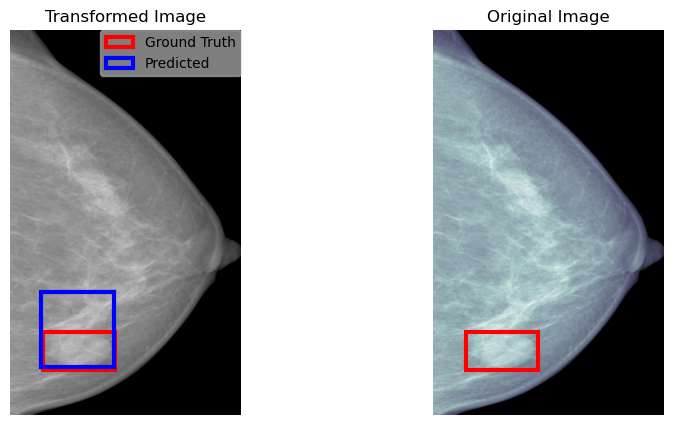

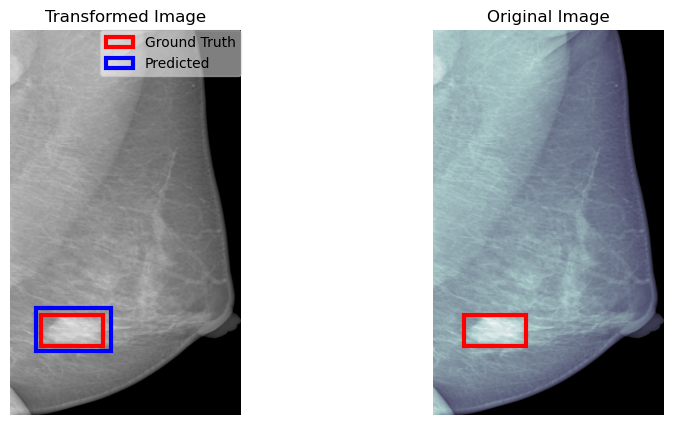

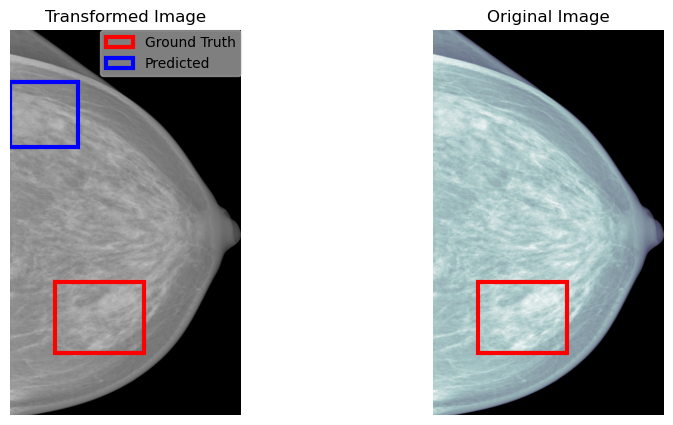

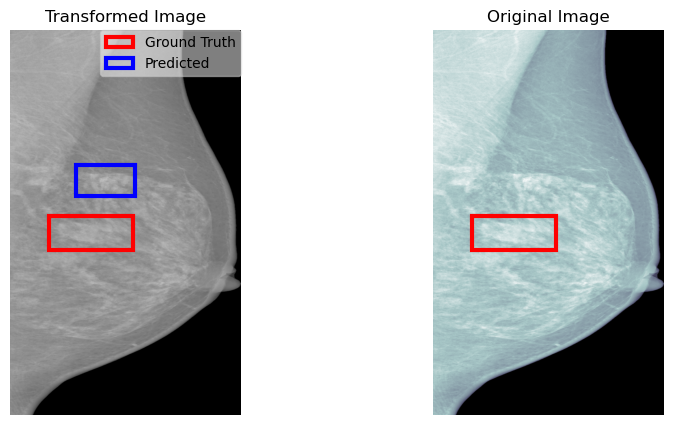

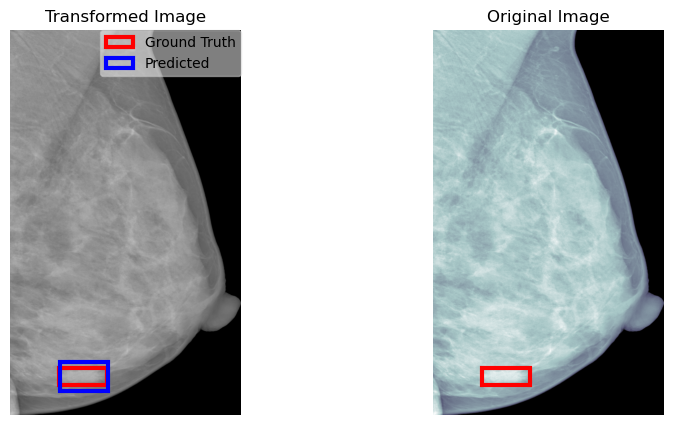

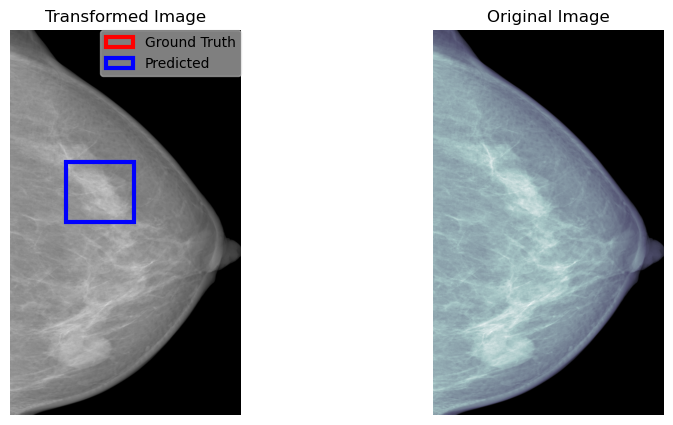

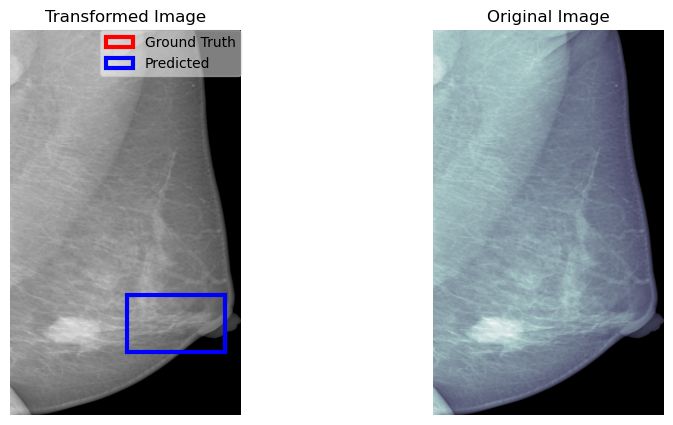

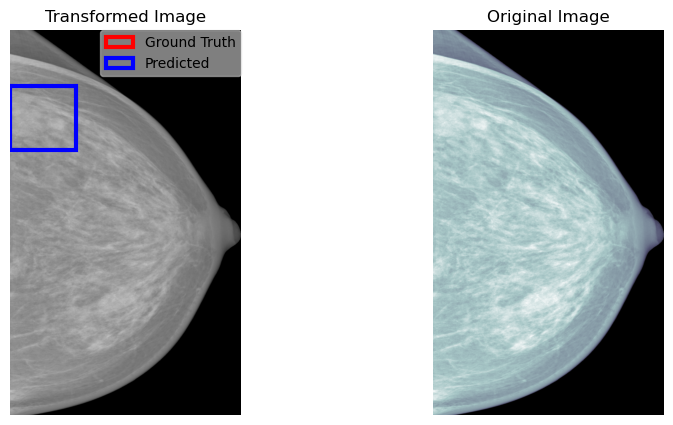

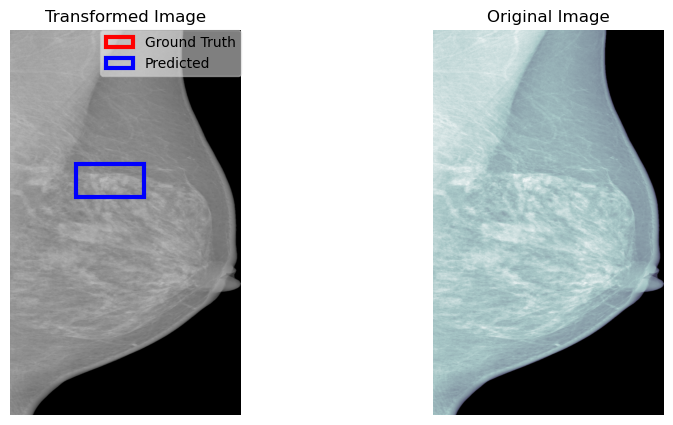

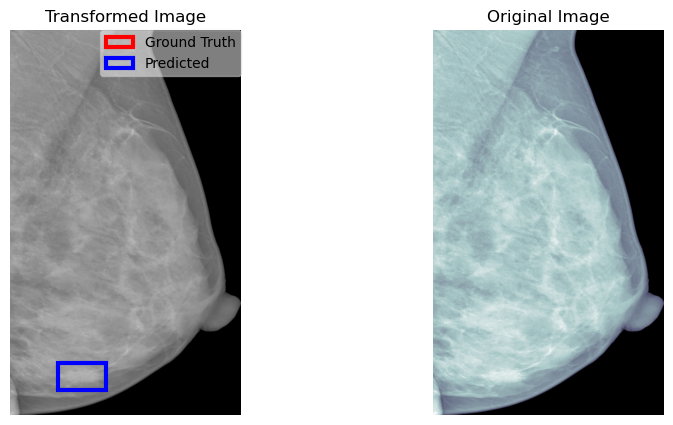

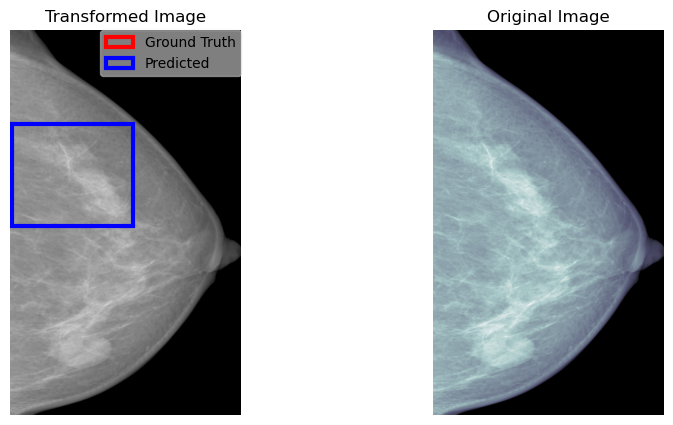

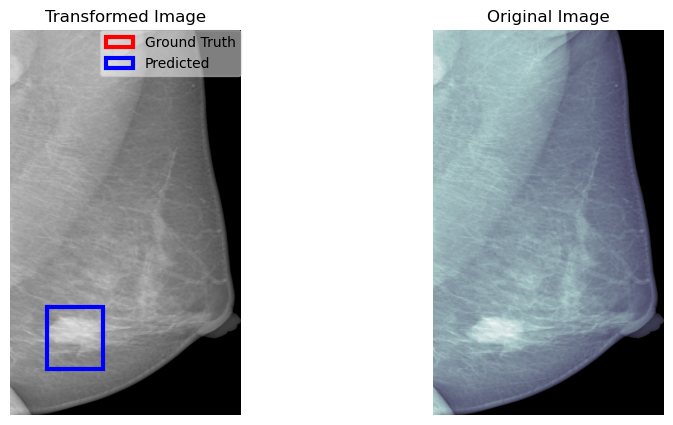

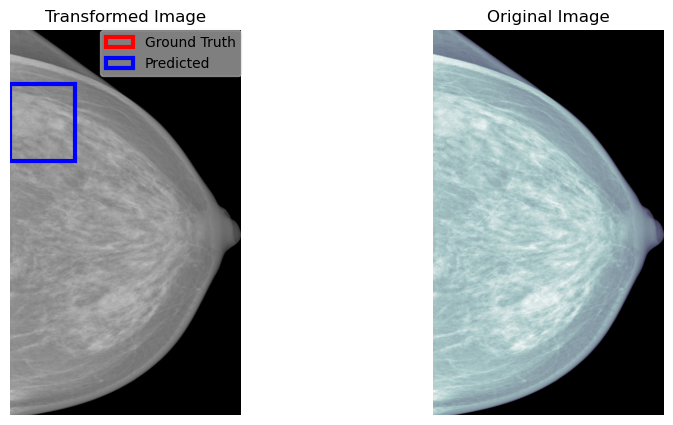

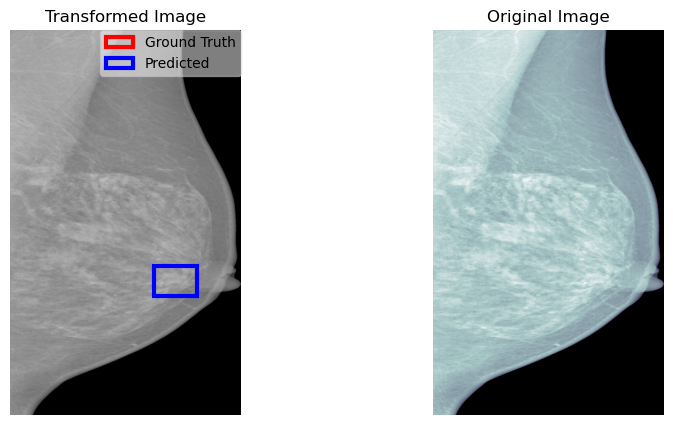

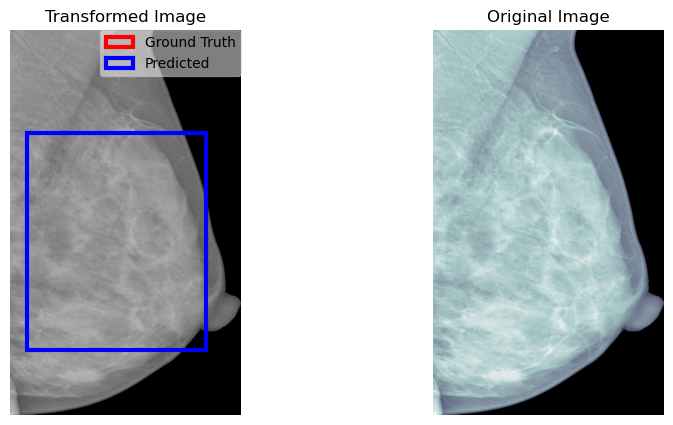

In [20]:

warnings.filterwarnings("ignore")

parser = argparse.ArgumentParser()
parser.add_argument('--checkpoints', metavar='DIR', default='./checkpoints/full', help='path to checkpoints')
parser.add_argument('--output_path', metavar='DIR', default='./out/full', help='path to output logs')
parser.add_argument("--data-dir", default="./", type=str, help="Path to data file")
parser.add_argument("--img-dir", default="/projectnb/ec500kb/materials/VinDr", type=str, help="Path to image file")
parser.add_argument("--csv-file", default="vin_dr_filtered_annotations.csv", type=str, help="data csv file")
parser.add_argument("--iou-threshold", default=0.5, type=float)
parser.add_argument("--score-threshold", default=0.2, type=float)
parser.add_argument("--alpha", default=10, type=float)
parser.add_argument("--sigma", default=15, type=float)
parser.add_argument("--p", default=1.0, type=float)
parser.add_argument("--mean", default=0.3089279, type=float)
parser.add_argument("--std", default=0.25053555408335154, type=float)
parser.add_argument("--focal-alpha", default=0.25, type=float)
parser.add_argument("--focal-gamma", default=1.0, type=float)
parser.add_argument("--seed", default=10, type=int)
parser.add_argument("--batch-size", default=2, type=int)
parser.add_argument("--epochs", default=100, type=int)
parser.add_argument("--lr", default=5e-5, type=float)
parser.add_argument("--detection-threshold", default=0.3, type=float)
parser.add_argument("--img-size", nargs='+', default=[1520, 912])
parser.add_argument("--resize", default=768, type=int)
parser.add_argument("--device", default="cuda", type=str)
parser.add_argument("--inference-mode", default='y', type=str)
parser.add_argument(
    "--concepts",
    nargs='+',
    default=[
        "Mass",
        "Asymmetry_Combined",
        #"Architectural_Distortion",
        "Suspicious_Calcification"
    ],
    help="Lesion concepts for detection"
)
parser.add_argument("--backbone", default="mammoclip_b5",
                    choices=["resnet18", "mammoclip_b5"],
                    help="Which backbone to use for RetinaNet")

parser.add_argument("--clip-chk-pt-path", default="/projectnb/ec500kb/projects/Fall_2025_Projects/Project_3/checkpoints/b5-model-best-epoch-7.tar",
                    type=str,
                    help="Path to Mammo-CLIP checkpoint (.tar) containing image_encoder")

parser.add_argument("--freeze-backbone", default="n", type=str,
                    choices=["y", "n"],
                    help="Freeze Mammo-CLIP image backbone or finetune it")
args = parser.parse_args(args=[])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.root = (f"lr_{args.lr}_epochs_{args.epochs}_concepts_{args.concepts[0]}_"
              f"wo_no_finding_alpha_{args.focal_alpha}_gamma_{args.focal_gamma}_score_th_{args.score_threshold}")

chk_pt_path, output_path, tb_logs_path = get_paths(args)
args.chk_pt_path = chk_pt_path
args.output_path = output_path
args.tb_logs_path = tb_logs_path

os.makedirs(chk_pt_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)
os.makedirs(tb_logs_path, exist_ok=True)

print("====================> Paths <====================")
print(f"checkpoint_path: {chk_pt_path}")
print(f"output_path: {output_path}")
print(f"tb_logs_path: {tb_logs_path}")
print('device:', device)
print('torch version:', torch.__version__)
print(f'No. of concept: {len(args.concepts)}')
print("====================> Paths <====================")

pickle.dump(args, open(os.path.join(output_path, f"seed_{args.seed}_train_configs.pkl"), "wb"))
torch.cuda.empty_cache()
do_experiements(args, device)


### 🤔 **Question**: Please provide an analysis of the comparative results obtained using the Cross-Entropy Loss and Focal Loss. (5 Points)

### **YOUR ANSWER**:
Focal Loss outperforms Cross-Entropy Loss, giving higher mAP (0.1323 vs. 0.1055) and accuracy (70.04% vs. 49.78%). This happens because Focal Loss reduces the influence of easy examples and forces the model to learn from hard ones, while Cross-Entropy treats all samples the same. As a result, the model trained with Focal Loss learns better decision boundaries and performs significantly better.